In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import scipy.stats as stats

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

import cartopy.feature as cf

from playsound import playsound

import sys
sys.path.append(os.path.abspath(".."))
from function import DOWN_raw
from function import ART_preprocessing as ART_pre

import warnings
warnings.filterwarnings('ignore')

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


## SATELLITE products
## Export Quantiles, Weibull Param and Relative Errors for each region as csv

In [2]:
# font = 'SAT'
font = 'DOWN'

In [3]:
# product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'ERA5', '3h'
product, time_reso = 'GSMaP', '1dy'
# product, time_reso = 'MSWEP', '3h'
# product, time_reso = 'IMERG', '1dy'
# product, time_reso = 'CHIRPS', '1dy'
# product, time_reso = 'PERSIANN', '1dy'

In [4]:
QC_method = 'QCv1_Flag1'

In [5]:
lon_min, lon_max, lat_min, lat_max, area, toll = 6.5, 19, 36.5, 48, 'ITALY', 0.002

Tr = [5, 10, 20, 50, 100]
Fi = 1 - 1/np.array(Tr)

In [6]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [7]:
obs_base = os.path.join('/','media','arturo','T9','Data','Italy', 'stations', 'Italy_raingauges', 'QC_MIX')

# sat_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_DOWN')
sat_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_DOWN')

In [8]:
METADATA = pd.read_csv(os.path.join(obs_base, 'METADATA', 'METADATA_INTENSE_UPDATE.csv'))
METADATA.head(2)

,Unnamed: 0,File,ISO,Region,Code,Name,Elevation,Or_EPSG,CRS_E,CRS_N,...,Source,TimeZon,Elevation.1,Orig_EPSG,Year_Start,Year_End,INTENSE_Resp,TimeZone,elevation_DEM,Elevation_update
0,0,IT-322_AA_6535_0060_QCv1.csv,IT-322,Alto-Adige,AA_6535,VANDOIESDISOPRA,746.0,32632.0,710057.0,5187849.0,...,Alto-Adige,UTC,NaN,NaN,NaN,NaN,NaN,NaN,745.9,746.0
1,1,IT-322_AA_5650_0060_QCv1.csv,IT-322,Alto-Adige,AA_5650,SELVADEIMOLINI,1141.0,32632.0,718972.0,5196967.0,...,Alto-Adige,UTC,NaN,NaN,NaN,NaN,NaN,NaN,1140.0,1141.0


## Load ISO regions and names

In [9]:
ISO_names = pd.read_csv(os.path.join('/','media','arturo','T9','Data','Italy', 'stations', 'Italy_raingauges', 'ISO_IT_REGION_EN.csv'))
ISO_names.head(2)

,Region,ISO
0,Alto Adige,IT-322
1,Aosta Valley,IT-230


## Load ENSEMBLE data

In [10]:
dir_in = os.path.join(sat_base, f'ITALY_DOWN_{product}_{time_reso}_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc')

data = xr.open_dataset(dir_in)
data = data.sortby('lat') 

lat_sat = data.lat.values
lon_sat = data.lon.values
lon2d_sat, lat2d_sat = np.meshgrid(lon_sat, lat_sat)

Sat_year = data.year.values

print(f'Load {font} parameters')
if font == 'SAT':
    Sat_NYd = data.NYs.values
    Sat_CYd = data.CYs.values
    Sat_WYd = data.WYs.values
elif font == 'DOWN':
    Sat_NYd = data.NYd.values
    Sat_CYd = data.CYd.values
    Sat_WYd = data.WYd.values
else:
    print('Font dont found')
    sys.exit()

Load DOWN parameters


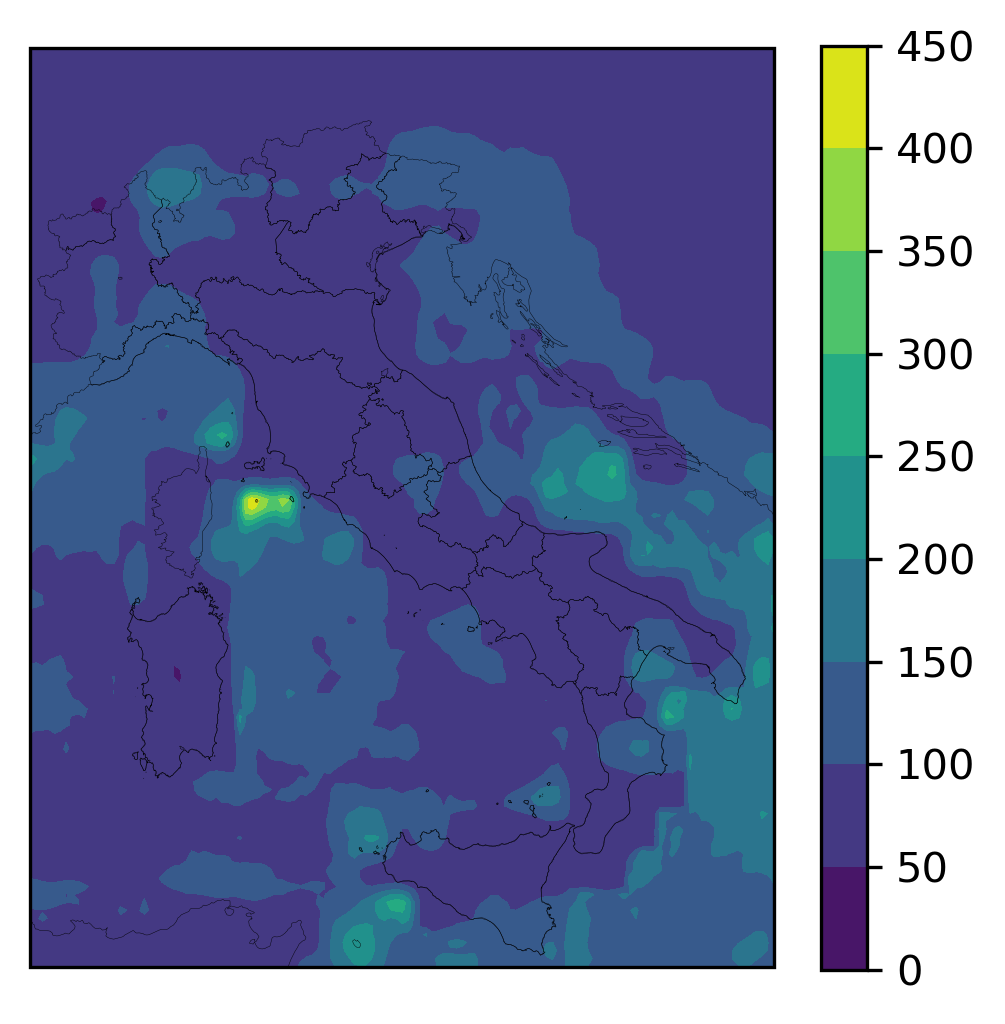

In [11]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,4),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1,color='k')
REGIONS.plot(facecolor='None', ax=ax1, linewidth=0.1, zorder=10)
a1 = ax1.contourf(lon2d_sat, lat2d_sat, data.Mev_d[3,:,:],axis=0)
cbar = plt.colorbar(a1)


## Choose the Region

In [12]:
Tr_index = 3
print(f'Tr: {Tr[Tr_index]} years')

Tr: 50 years


In [13]:
ISO_names["ISO_num"] = ISO_names["ISO"].str.split("-").str[1].astype(int)
ISO_names = ISO_names.sort_values("ISO_num").drop(columns="ISO_num").reset_index(drop=True)
ISO_names.head(5)

,Region,ISO
0,Piedmont,IT-210
1,Aosta Valley,IT-230
2,Lombardy,IT-250
3,Trentino,IT-321
4,Alto Adige,IT-322


In [14]:
diccionario_OBS_WN = {}
diccionario_OBS_WC = {}
diccionario_OBS_WW = {}

diccionario_SAT_WN = {}
diccionario_SAT_WC = {}
diccionario_SAT_WW = {}

diccionario_RE = {}
diccionario_LAT = {}
diccionario_LON = {}
diccionario_ELEV = {}

diccionario_Qobs = {}
diccionario_Qest = {}

for rr in range(len(ISO_names)):#len(ISO_names)
    region_ISO = ISO_names.iloc[rr]['ISO']
    region_label = ISO_names[ISO_names['ISO']==region_ISO]

    print(f'{rr+1}: {region_label['Region'].values[0]} ({region_ISO})')

    METADATA_clear = METADATA[METADATA['ISO']==region_ISO].reset_index(inplace=False)

    SAT_WN, SAT_WC, SAT_WW = [], [], []
    OBS_WN, OBS_WC, OBS_WW = [], [], []
    LAT, LON, RE_50, ELEV = [], [], [], []
    Qobs, Qest = [], []
    for nn in range(len(METADATA_clear)):#len(METADATA_clear)
        filename = f'{METADATA_clear['File'].values[nn]}'
        lat_obs = METADATA_clear['Lat'][nn]
        lon_obs = METADATA_clear['Lon'][nn]
        elev_obs = METADATA_clear['Elevation_update'][nn]

        OBS_pd = pd.read_csv(os.path.join(obs_base, 'DATA_1dy', 'statistics', QC_method, region_ISO, filename))
        OBS_pd = OBS_pd[(OBS_pd['Year']>=2002)&(OBS_pd['Year']<=2023)].reset_index(drop=True)
        if len(OBS_pd) == 0:
            continue
        
        else:
            OBS_N = OBS_pd['N'].values
            OBS_C = OBS_pd['C'].values
            OBS_W = OBS_pd['W'].values
            OBS_Y = OBS_pd['Year'].values

            mask = ~np.isnan(OBS_N)

            OBS_N = OBS_N[mask]
            OBS_C = OBS_C[mask]
            OBS_W = OBS_W[mask]
            OBS_Y = OBS_Y[mask]

            if len(OBS_Y) >= 8: # greather than 8 years

                x0 = np.nanmean(OBS_C)
                OBS_Q, flag = DOWN_raw.mev_quant_update(Fi, x0, OBS_N, OBS_C, OBS_W, thresh=1)
                OBS_Q2 = np.where(flag, OBS_Q, np.nan)

                distances = ART_pre.haversine(lat2d_sat, lon2d_sat, lat_obs, lon_obs)
                min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
                Sat_NYd_ = Sat_NYd[:,min_index[0],min_index[1]]
                Sat_CYd_ = Sat_CYd[:,min_index[0],min_index[1]]
                Sat_WYd_ = Sat_WYd[:,min_index[0],min_index[1]]

                Sat_pd = pd.DataFrame({'Year':Sat_year, 'N':Sat_NYd_, 'C':Sat_CYd_, 'W':Sat_WYd_})
                Sat_pd_filtered = Sat_pd[Sat_pd['Year'].isin(OBS_pd['Year'])].reset_index()
                # Sat_pd_filtered = Sat_pd.set_index('Year').loc[OBS_pd['Year']].reset_index()

                SAT_N = Sat_pd_filtered['N'].values
                SAT_C = Sat_pd_filtered['C'].values
                SAT_W = Sat_pd_filtered['W'].values
                SAT_Y = Sat_pd_filtered['Year'].values

                SAT_N = SAT_N[mask]
                SAT_C = SAT_C[mask]
                SAT_W = SAT_W[mask]
                SAT_Y = SAT_Y[mask]

                if len(OBS_Y) != len(SAT_Y):
                    print('ERROR')
                    sys.exit()
                else:
                    
                    OBS_WN.extend(OBS_N)
                    OBS_WC.extend(OBS_C)
                    OBS_WW.extend(OBS_W)
                    
                    SAT_WN.extend(SAT_N)
                    SAT_WC.extend(SAT_C)
                    SAT_WW.extend(SAT_W)
                    
                    x0 = np.nanmean(SAT_C)
                    SAT_Q, flag = DOWN_raw.mev_quant_update(Fi, x0, SAT_N, SAT_C, SAT_W, thresh=1)
                    SAT_Q2 = np.where(flag, SAT_Q, np.nan)

                relative_e_50 = (SAT_Q2[3] - OBS_Q2[3])/OBS_Q2[3]

                LAT.append(float(lat_obs))
                LON.append(float(lon_obs))
                RE_50.append(float(relative_e_50))
                ELEV.append(float(elev_obs))
                Qobs.append(float(OBS_Q2[3]))
                Qest.append(float(SAT_Q2[3]))

            else:        
                continue

            RE_50_M = np.array(RE_50)
            RE_50_M = RE_50_M[(RE_50_M>-1)&(RE_50_M<1)]
            diccionario_RE[region_ISO] = RE_50_M

            LAT_M = np.array(LAT)
            LAT_M = LAT_M[(np.array(RE_50)>-1)&(np.array(RE_50)<1)]
            diccionario_LAT[region_ISO] = LAT_M

            LON_M = np.array(LON)
            LON_M = LON_M[(np.array(RE_50)>-1)&(np.array(RE_50)<1)]
            diccionario_LON[region_ISO] = LON_M

            ELEV_M = np.array(ELEV)
            ELEV_M = ELEV_M[(np.array(RE_50)>-1)&(np.array(RE_50)<1)]
            diccionario_ELEV[region_ISO] = ELEV_M

            Qobs_M = np.array(Qobs)
            Qobs_M = Qobs_M[(np.array(RE_50)>-1)&(np.array(RE_50)<1)]
            diccionario_Qobs[region_ISO] = Qobs_M

            Qest_M = np.array(Qest)
            Qest_M = Qest_M[(np.array(RE_50)>-1)&(np.array(RE_50)<1)]
            diccionario_Qest[region_ISO] = Qest_M

            OBS_WN_N = np.array(OBS_WN)
            diccionario_OBS_WN[region_ISO] = OBS_WN_N
            
            OBS_WC_N = np.array(OBS_WC)
            diccionario_OBS_WC[region_ISO] = OBS_WC_N
            
            OBS_WW_N = np.array(OBS_WW)
            diccionario_OBS_WW[region_ISO] = OBS_WW_N

            SAT_WN_N = np.array(SAT_WN)
            diccionario_SAT_WN[region_ISO] = SAT_WN_N
            
            SAT_WC_N = np.array(SAT_WC)
            diccionario_SAT_WC[region_ISO] = SAT_WC_N
            
            SAT_WW_N = np.array(SAT_WW)
            diccionario_SAT_WW[region_ISO] = SAT_WW_N


1: Piedmont (IT-210)
2: Aosta Valley (IT-230)
3: Lombardy (IT-250)
4: Trentino (IT-321)
5: Alto Adige (IT-322)
6: Veneto (IT-340)
7: Friuli-Venezia Giulia (IT-360)
8: Liguria (IT-420)
9: Emilia-Romagna (IT-450)
10: Tuscany (IT-520)
11: Umbria (IT-550)
12: Marche (IT-570)
13: Lazio (IT-620)
14: Abruzzo (IT-650)
15: Molise (IT-670)
16: Campania (IT-720)
17: Apulia (IT-750)
18: Basilicata (IT-770)
19: Calabria (IT-780)
20: Sicily (IT-820)
21: Sardinia (IT-880)


## Extreme Quantiles Tr=50 yrs

In [15]:
diccionario_Qobs = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_Qobs.items()]))
diccionario_Qest = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_Qest.items()]))

## Weibull Parameters

In [16]:
diccionario_OBS_WN = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_OBS_WN.items()]))
diccionario_OBS_WC = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_OBS_WC.items()]))
diccionario_OBS_WW = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_OBS_WW.items()]))

## Relative Error and Position

In [17]:
diccionario_SAT_WN = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_SAT_WN.items()]))
diccionario_SAT_WC = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_SAT_WC.items()]))
diccionario_SAT_WW = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_SAT_WW.items()]))

diccionario_RE = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_RE.items()]))
diccionario_LAT = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_LAT.items()]))
diccionario_LON = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_LON.items()]))
diccionario_ELEV = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in diccionario_ELEV.items()]))

In [18]:
diccionario_Qobs[diccionario_Qobs>500]=np.nan
diccionario_Qest[diccionario_Qobs>500]=np.nan

diccionario_OBS_WN[diccionario_Qobs>500]=np.nan
diccionario_OBS_WC[diccionario_Qobs>500]=np.nan
diccionario_OBS_WW[diccionario_Qobs>500]=np.nan

diccionario_SAT_WN[diccionario_Qobs>500]=np.nan
diccionario_SAT_WC[diccionario_Qobs>500]=np.nan
diccionario_SAT_WW[diccionario_Qobs>500]=np.nan

diccionario_RE[diccionario_Qobs>500]=np.nan
diccionario_LAT[diccionario_Qobs>500]=np.nan
diccionario_LON[diccionario_Qobs>500]=np.nan
diccionario_ELEV[diccionario_Qobs>500]=np.nan

## Export DataFrames as csv

In [19]:
dir_out = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'{font}_{product}_OBS_Q50.csv')
print(f'Export as: {dir_out}')
diccionario_Qobs.to_csv(dir_out, header=True, index=False)

dir_out = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'{font}_{product}_Q50.csv')
print(f'Export as: {dir_out}')
diccionario_Qest.to_csv(dir_out, header=True, index=False)

Export as: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/QC_MIX/DATA_1dy/RE_ENSEMBLE_SAT/DOWN_GSMaP_OBS_Q50.csv
Export as: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/QC_MIX/DATA_1dy/RE_ENSEMBLE_SAT/DOWN_GSMaP_Q50.csv


In [20]:
dir_out = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'{font}_{product}_OBS_Elev.csv')
print(f'Export as: {dir_out}')
diccionario_ELEV.to_csv(dir_out, header=True, index=False)

dir_out = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'{font}_{product}_OBS_relative_error_lat.csv')
print(f'Export as: {dir_out}')
diccionario_LAT.to_csv(dir_out, header=True, index=False)

dir_out = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'{font}_{product}_OBS_relative_error_lon.csv')
print(f'Export as: {dir_out}')
diccionario_LON.to_csv(dir_out, header=True, index=False)

Export as: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/QC_MIX/DATA_1dy/RE_ENSEMBLE_SAT/DOWN_GSMaP_OBS_Elev.csv
Export as: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/QC_MIX/DATA_1dy/RE_ENSEMBLE_SAT/DOWN_GSMaP_OBS_relative_error_lat.csv
Export as: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/QC_MIX/DATA_1dy/RE_ENSEMBLE_SAT/DOWN_GSMaP_OBS_relative_error_lon.csv


In [21]:
dir_out = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'{font}_{product}_Weibull_N.csv')
print(f'Export as: {dir_out}')
diccionario_SAT_WN.to_csv(dir_out, header=True, index=False)

dir_out = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'{font}_{product}_Weibull_C.csv')
print(f'Export as: {dir_out}')
diccionario_SAT_WC.to_csv(dir_out, header=True, index=False)

dir_out = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'{font}_{product}_Weibull_W.csv')
print(f'Export as: {dir_out}')
diccionario_SAT_WW.to_csv(dir_out, header=True, index=False)

Export as: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/QC_MIX/DATA_1dy/RE_ENSEMBLE_SAT/DOWN_GSMaP_Weibull_N.csv
Export as: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/QC_MIX/DATA_1dy/RE_ENSEMBLE_SAT/DOWN_GSMaP_Weibull_C.csv
Export as: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/QC_MIX/DATA_1dy/RE_ENSEMBLE_SAT/DOWN_GSMaP_Weibull_W.csv


In [22]:
dir_out = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'{font}_{product}_relative_error.csv')
print(f'Export as: {dir_out}')
diccionario_RE.to_csv(dir_out, header=True, index=False)

Export as: /media/arturo/T9/Data/Italy/stations/Italy_raingauges/QC_MIX/DATA_1dy/RE_ENSEMBLE_SAT/DOWN_GSMaP_relative_error.csv


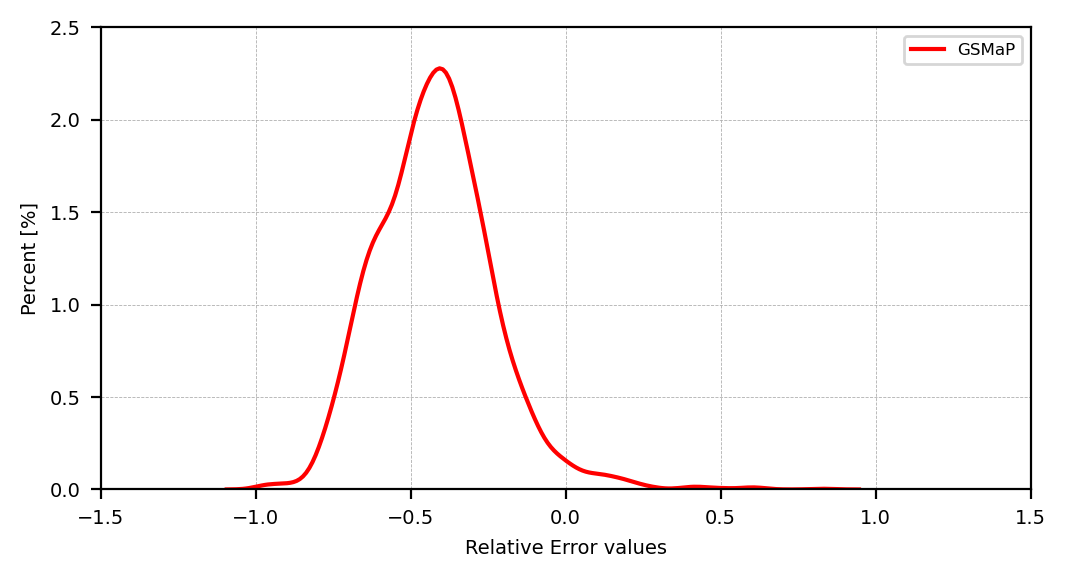

In [23]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(diccionario_RE.values.flatten(),color='r',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'{product}')

ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.set_xlabel('Relative Error values',fontsize=7)
ax1.legend(fontsize=6, loc=0, ncol=2)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.tick_params(axis='both', which='major', labelsize=7)

In [24]:
playsound("../sound/HOMER_DOH.mp3")